In [1]:

import numpy as np
import gurobipy as gp
from gurobipy import GRB, quicksum
from tqdm.notebook import trange

np.set_printoptions(suppress=True)

from constants import (
    MAX_TAXI_ZONE_ID,
    location_ids,
    excluded_location_ids,
    location_id_to_index,
    num_locations,
    taxi_type,
)

import matplotlib.pyplot as plt

#### Note that here $\lambda$:=$N\cdot \hat{\lambda}$

$$\begin{align*}
\max_{\bar{e}, \bar{f}, \bar{a}} \quad & \frac{1}{K\Delta} \sum_{k=0}^{K-1} \sum_{i=1}^r \sum_{j=1}^r \bar{a}_i \lambda_i(t + k\Delta) P_{ij}(t + k\Delta) c_{ij}(t + k\Delta) \cdot\Delta \\
\text{subject to} \quad 
& \frac{1}{K\Delta} \sum_{k=0}^{K-1} \lambda_i(t + k\Delta) P_{ij}(t + k\Delta) \bar{a}_i \cdot \Delta  = \frac{1}{K\Delta} \sum_{k=0}^{K-1} \mu_{ij}(t + k\Delta) \bar{f}_{ij} \cdot \Delta \\
& \frac{1}{K\Delta} \left(\sum_{k=0}^{K-1} \mu_{ij}(t + k\Delta) \cdot \Delta\right) \bar{e}_{ij} \leq \sum_{j=1}^r \left(\frac{1}{K\Delta} \sum_{k=0}^{K-1} \mu_{ji}(t + k\Delta)  \cdot \Delta \right)\bar{f}_{ji}\\
& \sum_{\substack{j=1 \\ j \neq i}}^r \frac{1}{K\Delta} \left(\sum_{k=0}^{K-1} \mu_{ji}(t + k\Delta) \cdot \Delta\right) \bar{e}_{ji} \leq \frac{1}{K\Delta}\left(\sum_{k=0}^{K-1} \lambda_i(t + k\Delta)\cdot \Delta \right) \bar{a}_i \\
& \frac{1}{K\Delta} \left(\sum_{k=0}^{K-1} \lambda_i(t + k\Delta)\cdot \Delta \right) \bar{a}_i  \\
&\quad\leq \sum_{\substack{j=1 \\ j \neq i}}^r \left(\frac{1}{K\Delta} \sum_{k=0}^{K-1} \mu_{ji}(t + k\Delta)  \cdot \Delta \right)\bar{e}_{ji} + \sum_{j=1}^r \left(\frac{1}{K\Delta} \sum_{k=0}^{K-1} \mu_{ji}(t + k\Delta) \cdot \Delta \right)\bar{f}_{ji} \\
& \frac{1}{K\Delta} \left(\sum_{k=0}^{K-1} \lambda_i(t + k\Delta)\cdot \Delta \right) \bar{a}_i + \sum_{\substack{j=1 \\ j \neq i}}^r \left(\frac{1}{K\Delta} \sum_{k=0}^{K-1} \mu_{ij}(t + k\Delta)  \cdot \Delta \right)\bar{e}_{ij} \\
&\quad = \sum_{\substack{j=1 \\ j \neq i}}^r \left(\frac{1}{K\Delta} \sum_{k=0}^{K-1} \mu_{ji}(t + k\Delta)  \cdot \Delta \right)\bar{e}_{ji} + \sum_{j=1}^r \left(\frac{1}{K\Delta} \sum_{k=0}^{K-1} \mu_{ji}(t + k\Delta) \cdot \Delta \right)\bar{f}_{ji} \\
& e_{ij}, f_{ij} \in [0, 1], \sum_{i=1}^r \sum_{j=1}^r e_{ij} + f_{ij} = 1\\
& 0 \leq \bar{a}_i \leq 1
\end{align*}
$$

In [ ]:
Delta = 60 # in minutes
T_max = int(24 * (60 / Delta))
print(T_max)

4



--- Loading Consolidated Data ---
Data loaded successfully.


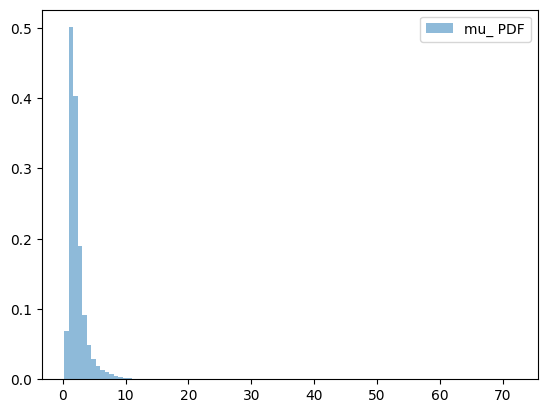

(4, 234, 234)
all-region arrival rate w.r.t. N:
 [1.17575198 3.58649306 3.79199008 4.208313  ]


In [3]:
print("\n--- Loading Consolidated Data ---")
data_filename = "2Months_trip_data_.npz"
try:
    with np.load(data_filename) as data:
        trip_counts = data['trip_counts']
        num_dates = data['num_dates'].item()
        # all_trip_times = data['all_trip_times']
        # key_counts = data['key_counts']
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: Consolidated data file {data_filename} not found. Cannot proceed with tasks.")
    exit()

with np.load('mu_calculated.npz') as data:
    mu = data['mu']

plt.hist(mu.flatten(), bins=100, density=True, alpha=0.5, label='mu_ PDF')
plt.legend()
plt.show()

# mask trip_counts by 1 where 0
trip_counts[trip_counts == 0] = 1
print(trip_counts.shape)
# compute arrival rate
lambda_ = trip_counts.sum(axis=2) / (Delta / 60 * num_dates)
N = 8000 

''' This step is IMPORTANT '''
lambda_ = lambda_ / N

print('all-region arrival rate w.r.t. N:\n',lambda_.sum(axis=1))
# normalize trip_counts
P = trip_counts / trip_counts.sum(axis=2, keepdims=True)

In [14]:
T, R, _ = P.shape
print(np.all(P>0))
print(P.shape)

True
(4, 234, 234)


In [5]:
def compute_time_averaged(lambda_, mu, t_start, K, T_max):
    time_indices = [(t_start + k) % T_max for k in range(K)]
    lambda_avg = np.mean(lambda_[time_indices, :], axis=0)         # shape: (r,)
    mu_avg = np.mean(mu[time_indices, :, :], axis=0)               # shape: (r, r)
    return lambda_avg, mu_avg


In [ ]:
def solve_routing(lambda_, mu, P, Delta, t_start=0, K=6):
    lambda_avg, mu_avg = compute_time_averaged(lambda_, mu, t_start, K, T_max)
    P_avg = np.mean(P[[(t_start + k) % T_max for k in range(K)], :, :], axis=0) 


    r = lambda_.shape[1]
    model = gp.Model("lookahead_empty_car_routing")
    model.setParam('OutputFlag', 0)
    
    # scaling e, f, and a by this factor for numeric stability
    SCALE = 1000
    
    # Variables
    a = model.addVars(r, lb=0, ub=1, name="a")
    e = model.addVars(r, r, lb=0, ub=SCALE, name="e")
    f = model.addVars(r, r, lb=0, ub=SCALE, name="f")

    # Objective
    model.setObjective(
        quicksum(a[i] * lambda_avg[i] * P_avg[i, j] for i in range(r) for j in range(r)),
        GRB.MAXIMIZE
    )

    # Eq. 10a: Ride flow balance
    ride_flow_expr = {
        (i, j): SCALE * a[i] * lambda_avg[i] * P_avg[i, j] - mu_avg[i, j] * f[i, j]
        for i in range(r) for j in range(r)
    }
    model.addConstrs((ride_flow_expr[i, j] == 0 for i in range(r) for j in range(r)), name="ride_flow_balance")

    # Eq. 10b: Empty car flow balance
    model.addConstrs((
        mu_avg[i, j] * e[i, j] <= quicksum(mu_avg[l, i] * f[l, i] for l in range(r))
        for i in range(r) for j in range(r) if i != j
    ), name="empty_car_flow")

    # Eq. 10c: Supply conservation (lower bound)
    model.addConstrs((
        quicksum(mu_avg[j, i] * e[j, i] for j in range(r) if j != i) <= SCALE * lambda_avg[i] * a[i]
        for i in range(r)
    ), name="supply_lower")
    
    # Eq. 10c: Supply conservation (upper bound)
    model.addConstrs((
        SCALE * lambda_avg[i] * a[i] <=
        quicksum(mu_avg[j, i] * e[j, i] for j in range(r) if j != i) +
        quicksum(mu_avg[j, i] * f[j, i] for j in range(r))
        for i in range(r)
    ), name="supply_upper")
    
    # Eq. 10d: Car flow balance
    model.addConstrs((
        SCALE * lambda_avg[i] * a[i] +
        quicksum(mu_avg[i, j] * e[i, j] for j in range(r) if j != i)
        ==
        quicksum(mu_avg[j, i] * e[j, i] for j in range(r) if j != i) +
        quicksum(mu_avg[j, i] * f[j, i] for j in range(r))
        for i in range(r)
    ), name="car_flow_balance")
     
    # Unit mass constraint
    model.addConstr(
        quicksum(e[i,j] + f[i,j] for i in range(r) for j in range(r)) == SCALE,
        name="unit_mass"
    )
    
    model.optimize()
    
    return model, a, e, f, lambda_avg, mu_avg

def compute_q_matrix(a, e, f, mu_avg, lambda_avg):
    """
    a, e, f: 2D array of shape (r, r)
    mu_avg: 2D array of shape (r, r) averaged over time
    lambda_avg: 1D array of shape (r,) averaged over time
    """
    r = len(a)
    q = np.zeros((r, r))

    # Precompute denominator for qij and qii
    for i in range(r):
        denom = sum(mu_avg[k, i] * f[k, i] for k in range(r))
        # print(f"Denominator is zero for i={i}. Setting q[{i}, :] to 0.")
        for j in range(r):
            if i != j:
                if denom > 0:
                    q[i, j] = mu_avg[i, j] * e[i, j] / denom
                else:
                    
                    q[i, j] = 0.0
            else:
                # qii computation
                numerator = lambda_avg[i] * a[i] - sum(
                    mu_avg[k, i] * e[k, i] for k in range(r) if k != i
                )
                q[i, i] = numerator / denom if denom > 0 else 0.0
            if q[i, j] < 0: print([(i,j),q[i, j]])
            elif q[i, j] > 1: print([(i,j),q[i, j]])
    return q

In [ ]:
def solve_Q(K):
    Qs = []
    for t_start in trange(0, T_max, 1):
        print(f"t_start: {t_start}")
        if T_max < K: K = 1
        model, a, e, f, lambda_avg, mu_avg = solve_routing(lambda_, mu, P, Delta, t_start=t_start, K=K)

        # Extract the values of the variables
        a_values = np.array([a[i].X for i in range(R)])
        e_values = np.array([[e[i,j].X for j in range(R)] for i in range(R)])
        f_values = np.array([[f[i,j].X for j in range(R)] for i in range(R)])

        normalizer = (e_values + f_values).sum()

        e_values /= normalizer
        f_values /= normalizer
            
        # Compute the Q matrix
        Q = compute_q_matrix(a_values, e_values, f_values, mu_avg, lambda_avg)
        
        # clip values close to 0
        Q[np.isclose(Q, 0, atol=1e-9)] = 0
        # normalize rows of Q to sum to 1
        Q = Q / Q.sum(axis=1, keepdims=True)
        
        Qs.append(Q)
        
        # check rows are nonnegative / no entries with absolute value > 1
        if not np.all(Q >= 0):
            print(f"Q matrix has negative entries at t_start={t_start}")
        if not np.all(np.abs(Q) <= 1):
            print(f"Q matrix has entries with absolute value > 1 at t_start={t_start}")
            
    # save Qs as len(Q) x r x r np.ndarray
    Qs = np.array(Qs)
    # np.savez(f'Qs_{K}.npz', Qs=Qs)
    return Qs

In [31]:
Q = solve_Q(6)
np.savez('Qs_4_6hrLkahd_N8000.npz',Q=Q)

  0%|          | 0/4 [00:00<?, ?it/s]

t_start: 0


/var/folders/fw/3qz88s_56zbglvp50xn4h6qw0000gn/T/ipykernel_22359/2736637753.py:25: RuntimeWarning: invalid value encountered in divide
  Q = Q / Q.sum(axis=1, keepdims=True)


Q matrix has negative entries at t_start=0
Q matrix has entries with absolute value > 1 at t_start=0
t_start: 1


KeyboardInterrupt: 

In [32]:
print(Q)

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
